In [1]:
%load_ext autoreload
%autoreload 2

In [7]:
import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np
import pandas as pd
from src.misc_utils import *
from src.model_utils import *
from src.sequence_utils import *
from src.portfolio import *
from yahooquery import Ticker
import os
from datetime import datetime,timedelta

In [11]:
today=datetime.today().strftime("%Y-%m-%d")

In [12]:
yesterday=(datetime.today()-timedelta(days=1)).strftime("%Y-%m-%d")

In [13]:
#remove_stock_list=pd.read_csv("drop_ticker.csv").ticker.values

In [14]:
if os.path.exists(f"data_{yesterday}.csv"):
    data=pd.read_csv(f"data_{yesterday}.csv")
else:
    tickers=pd.read_csv("tickers.csv").ticker.values.tolist()

    
    details=get_details(tickers,remove_ticker_list=["PPCB"])
    
    details.columns
    
    details=details[["ticker",
                     "industry",
                     "sector",
                     "country",
                     "fullExchangeName",
                     "quoteType",
                     "fiftyTwoWeekLow",
                     "fiftyTwoWeekHigh",
                     "marketCap",
                     "exchange",
                     "epsTrailingTwelveMonths",
                     "averageDailyVolume3Month",
                    "epsForward",
                    "forwardPE"]]
    
    details=details[details.quoteType=="EQUITY"]
    
    details=details[~details.country.isnull()]
    
    len(details[details.marketCap>details.marketCap.quantile(.95)])
    
    filtered_details=details[details.marketCap>details.marketCap.quantile(.95)]
    
    t=Ticker(filtered_details.ticker,asynchronous=True)
    
    data_init=t.history(start="2021-01-01",adj_ohlc=True,adj_timezone=False)
    
    data=data_init.reset_index()
    
    data=data.rename(columns={"symbol":"ticker","close":"Close"})
    
    data=data.merge(filtered_details.dropna(),on="ticker",how="inner")
    
    data.to_csv(f"data_{yesterday}.csv",index=False)

In [15]:
HORIZON=7
PRICE_COLUMN="Close"

HISTORY=14
FORECAST_STEPS=1
FUTURE=0
TARGET=f"log_return_{HORIZON}"

In [16]:
data["marketCap"]=(data["marketCap"]/data["marketCap"].max()).astype(float)
data["fiftyTwoWeekLow"]=(data["fiftyTwoWeekLow"]/data["fiftyTwoWeekLow"].max()).astype(float)
data["fiftyTwoWeekHigh"]=(data["fiftyTwoWeekHigh"]/data["fiftyTwoWeekHigh"].max()).astype(float)
data["averageDailyVolume3Month"]=(data["averageDailyVolume3Month"]/data["averageDailyVolume3Month"].max()).astype(float)

In [17]:
data=data[["date","ticker","industry","fullExchangeName","Close","marketCap","fiftyTwoWeekLow","fiftyTwoWeekHigh","averageDailyVolume3Month","epsTrailingTwelveMonths",
                 "averageDailyVolume3Month",
                "epsForward",
                "forwardPE"]]

In [18]:
data["date"]=pd.to_datetime(data["date"])

In [19]:
start_date=data.date.min()
end_date=data.date.max()


In [20]:
calendar=build_calendar(start_date=start_date,end_date=end_date,forecast_horizon=5*HORIZON,forecast_steps=FORECAST_STEPS)

calendar=get_train_val_test(calendar=calendar,end_date=end_date,horizon=HORIZON,test_ratio=.2,val_ratio=.0)

grid=build_grid(data,calendar)

data=data.merge(grid,on=["date","ticker"],how="right")

In [21]:
#data=shift(data,lag=HORIZON,column=PRICE_COLUMN)
#data["log_return"]=np.log(data[f"{PRICE_COLUMN}_shift_{HORIZON}"]/data[PRICE_COLUMN])

In [22]:
return_cols=[]
if HORIZON>1:
    for i in range(1,HORIZON+1):
        data=shift(data,lag=i,column=PRICE_COLUMN)
        return_cols.append(f"log_return_{i}_shift_-7")
        data[f"log_return_{i}"]=np.log(data[f"{PRICE_COLUMN}_shift_{i}"]/data[PRICE_COLUMN])
        data=shift(data,lag=-HORIZON,column=f"log_return_{i}")

In [23]:
data["log_return_7"]

0         0.011372
1        -0.016159
2         0.004256
3        -0.023885
4        -0.000151
            ...   
251801         NaN
251802         NaN
251803         NaN
251804         NaN
251805         NaN
Name: log_return_7, Length: 251806, dtype: float64

In [24]:
norm=Normaliser(target="Close",timeseries_id_column="ticker")

In [25]:
norm.fit(data[data.train==1])

In [26]:
data=norm.normalise(data)

In [27]:
num_features=["Close_scaled",
              #"marketCap",
              #"fiftyTwoWeekLow",
              #"fiftyTwoWeekHigh",
              #"averageDailyVolume3Month",
              #"epsTrailingTwelveMonths",
              #"averageDailyVolume3Month",
              #"epsForward",
              #"forwardPE"
]+return_cols#+ticker_return_features

In [28]:
initial_available_date=data[~data[TARGET].isnull()].date.min()

In [29]:
enc=Encoder(categoricals=[
    "industry",
    "fullExchangeName",
     "woy",
    "dow"
],method="ohe")

In [30]:
enc.fit(data[data.train==1])

In [31]:
features=enc.get_encoded_features()

In [32]:
features=features+num_features

In [33]:
data=enc.apply(data)

In [34]:
inference_date=data[(data.weekend==0)&(data.holiday=="no_holiday")&(data.date>data[~data[TARGET].isnull()][f"lag_date_Close_{HORIZON}"].max())].date.min()

In [35]:
sequencer=TimeseriesSquencer(
    features=features,
    target=TARGET,
    history=HISTORY,
    future=FUTURE,
    steps=FORECAST_STEPS,
    id_column="ticker",
    time_column="date",
    data_end_date=inference_date.strftime("%Y-%m-%d"),
    include_target_feature=False,
    extra_id_columns=[])

In [36]:
def same_sign(y_true,y_pred):
    return tf.reduce_sum(tf.abs(tf.cast(tf.sign(y_true),dtype=tf.float64)+tf.cast(tf.sign(y_pred),dtype=tf.float64))/2)/tf.reduce_sum(tf.abs(tf.cast(tf.sign(y_true),dtype=tf.float64)))

In [37]:
model = tf.keras.models.load_model(f"model-2023-06-06", custom_objects={'same_sign':same_sign})

In [38]:
start_date=inference_date-pd.Timedelta(days=100)

In [39]:
tmp=data[(data.working_day==1)&(data.date>=start_date)].copy()

In [40]:
data_dict=sequencer.sequence_timeseries(tmp)

In [41]:
result=get_predictions(model,tmp,data_dict,steps=[0])

480/480 [==============================] - 8s 14ms/step


In [42]:
rmse = lambda x,y:np.sqrt(np.mean((x-y)**2))

In [43]:
rmse_quality=result.dropna().groupby("ticker")[[TARGET,"pred_step_0"]].apply(lambda x: rmse(x.tail(30)[TARGET],x.tail(30)["pred_step_0"])).sort_values()

<AxesSubplot: xlabel='ticker'>

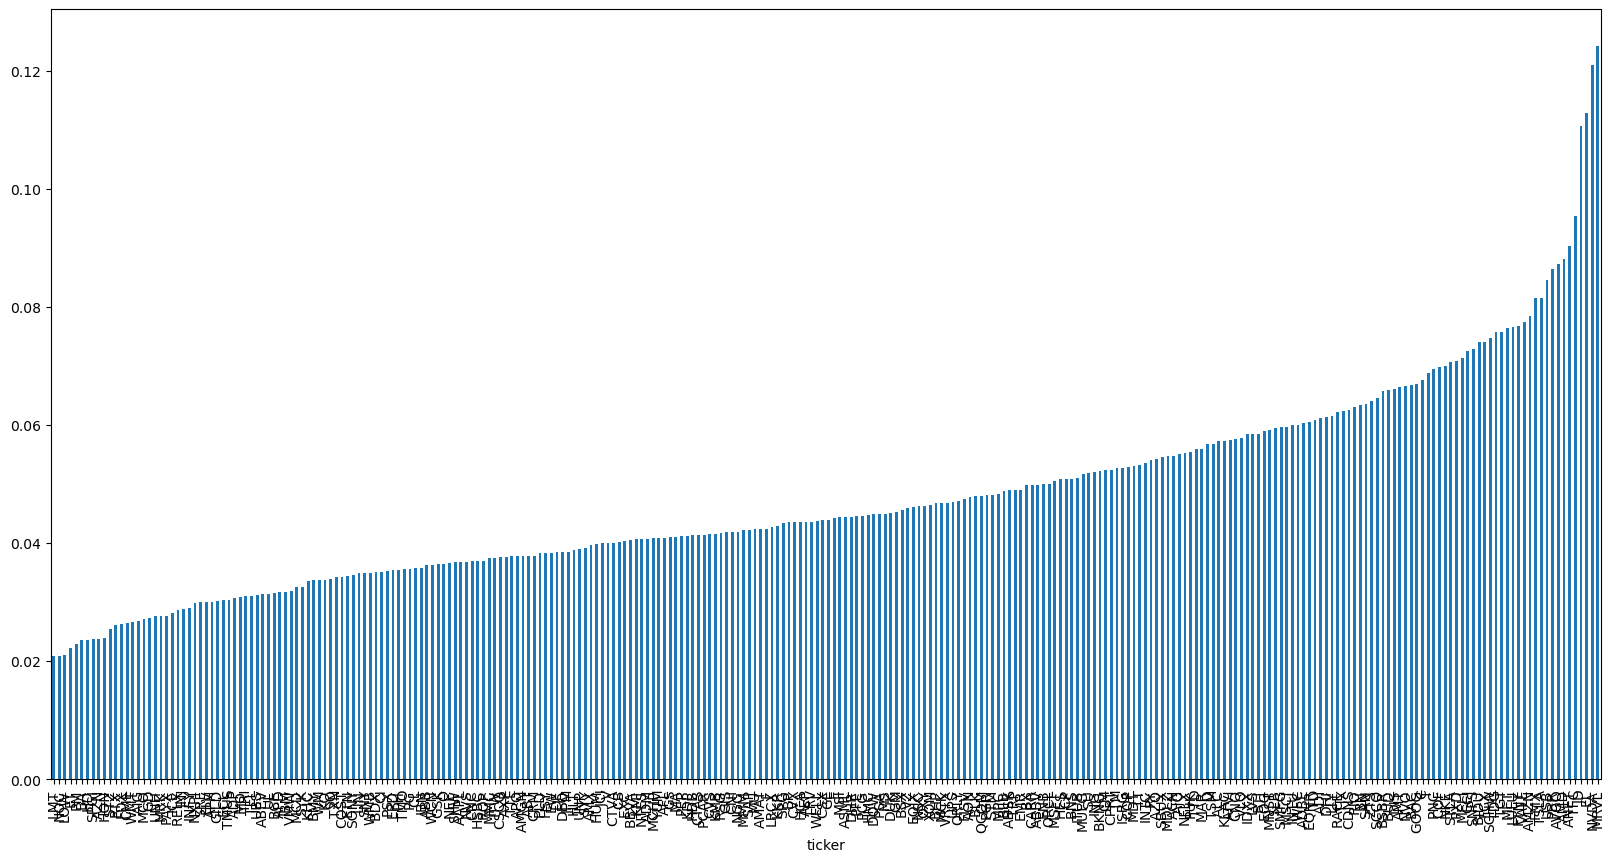

In [44]:
rmse_quality.plot.bar(figsize=(20,10))

In [45]:
result["zero"]=0

<AxesSubplot: >

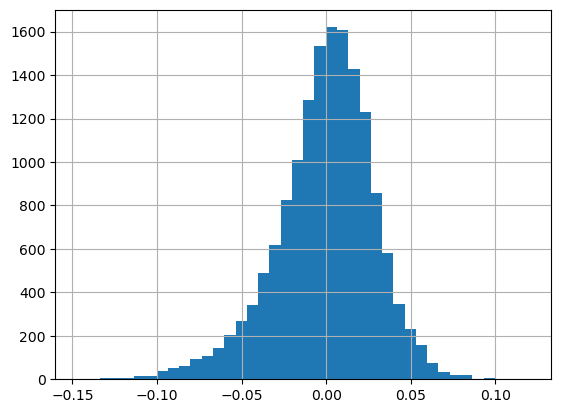

In [46]:
result.pred_step_0.hist(bins=40)

<AxesSubplot: >

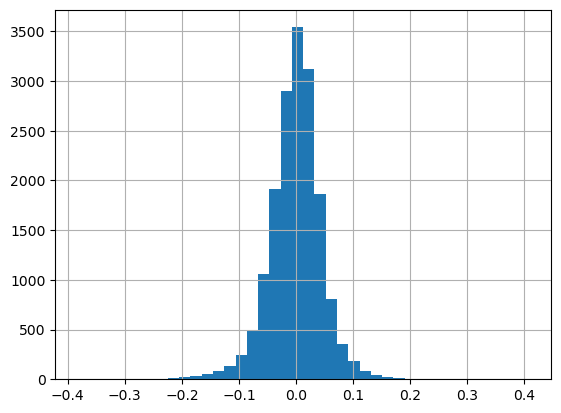

In [47]:
result.log_return_7.hist(bins=40)

<AxesSubplot: xlabel='date'>

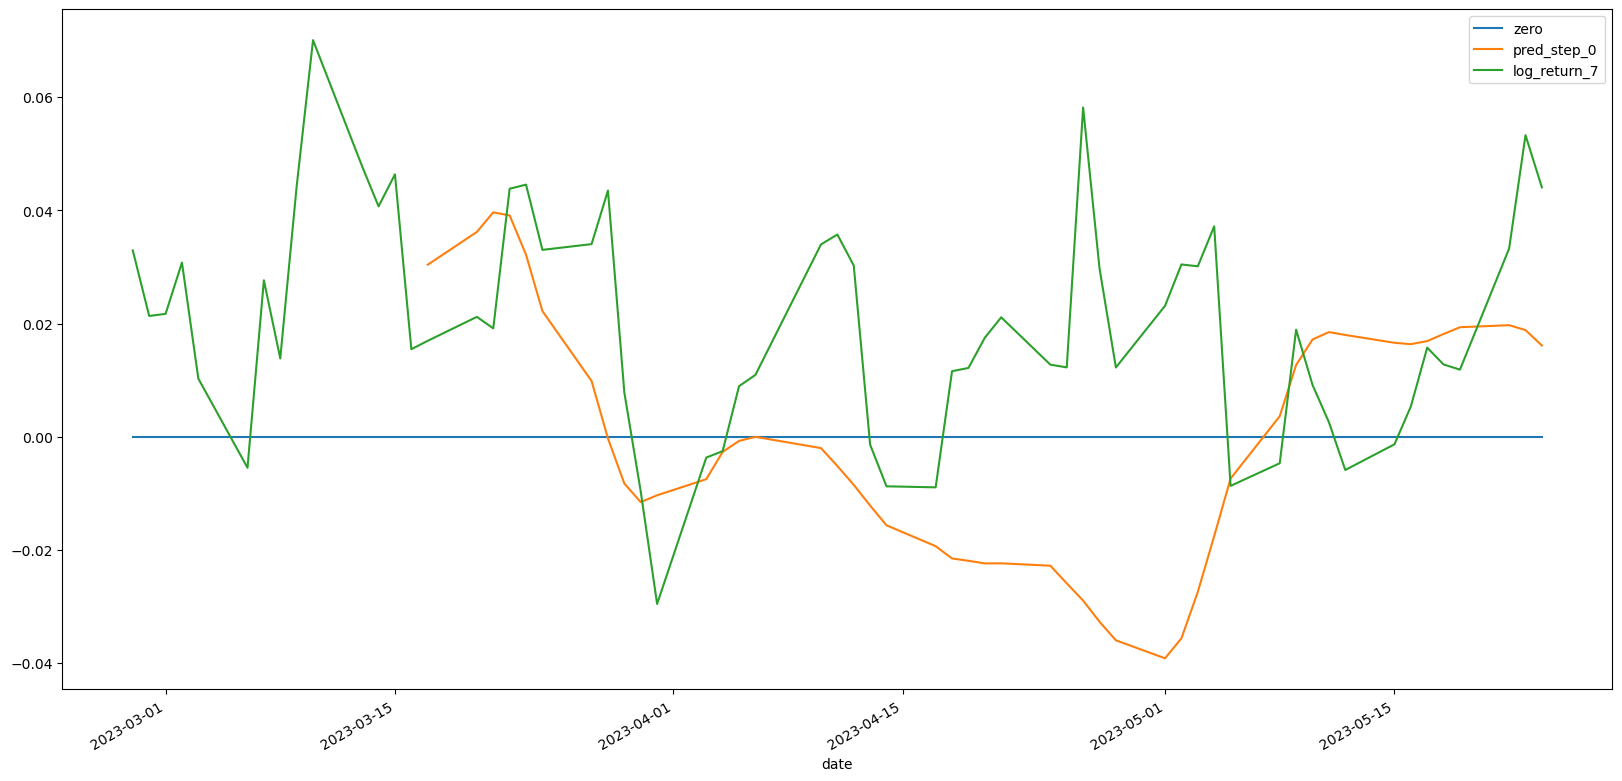

In [48]:
result[(result.test==1)&(result.ticker=="AAPL")].plot(x="date",y=["zero","pred_step_0",TARGET],figsize=(20,10))

In [49]:
RISK_LEVEL=0.01

In [50]:
MIN_BUDGET=50
MAX_BUDGET=500

In [51]:
## PREDICTED CLOSE FOR NEXT TRADING DAY
result=shift(result,lag=-1,column="Close")

In [52]:
expected_price="Close_shift_-1"

In [53]:
import datetime
today=datetime.datetime.today()

In [54]:
#result=result[result.date<=today]

In [55]:
tickers=result.ticker.unique()

In [56]:
MIN_BUDGET=0
MAX_BUDGET=1000
CNT_EXPERIMENTS=10

----
## SIMULATION
----

In [57]:
dates=[]
investments=[]
value_at_risk=[]
predicted_returns=[]
actual_returns=[]
maturity_date=[]
for date in result[result.date<=inference_date].date.unique()[-HORIZON-CNT_EXPERIMENTS-1:-HORIZON-1]:
    print(date)
    res,opt_tickers=optimise(prediction_results=result,
                 date=date,
                 min_budget=MIN_BUDGET,
                 max_budget=MAX_BUDGET,
                 tickers=tickers,
                 max_value_at_risk=10,
                 log_return_column=TARGET,
                 predicted_log_return_column="pred_step_0",
                 expected_price_column='Close_shift_-1',diversity=.99)
    dates.append(date)
    maturity_date.append(result[result.date==date]["lag_date_Close_7"].unique()[0])
    investments.append(investment(opt_tickers,res,result,price_column=PRICE_COLUMN,buy_date=date))
    investment(opt_tickers,res,result,price_column=PRICE_COLUMN,buy_date=date)
    value_at_risk.append(compute_value_at_risk(data=result,tickers=opt_tickers, 
                                                shares=res, buy_date=date, price_column='Close_shift_-1', 
                                                                                   log_return_column=TARGET,
                                                                                   confidence_level=0.99))
    predicted_returns.append(portfolio_buy_date_return(tickers=opt_tickers,shares=res,stock_log_return=result,buy_date=date,price_column='Close_shift_-1',log_return_column="pred_step_0"))
    actual_ret=portfolio_buy_date_return(tickers=opt_tickers,shares=res,stock_log_return=result,buy_date=date,price_column=PRICE_COLUMN,log_return_column=TARGET)
    print(actual_ret)
    actual_returns.append(actual_ret)
    
    

2023-05-11 00:00:00+00:00
Dropping the following ticker []
0.0917735565381925
2023-05-12 00:00:00+00:00
Dropping the following ticker []
0.07619647492504174
2023-05-15 00:00:00+00:00
Dropping the following ticker []
0.02249323192666969
2023-05-16 00:00:00+00:00
Dropping the following ticker []
0.10226024051524699
2023-05-17 00:00:00+00:00
Dropping the following ticker []
0.10498240881786486
2023-05-18 00:00:00+00:00
Dropping the following ticker []
0.12814535890897263
2023-05-19 00:00:00+00:00
Dropping the following ticker []
0.12358180229564743
2023-05-22 00:00:00+00:00
Dropping the following ticker []
0.09378100979835648
2023-05-23 00:00:00+00:00
Dropping the following ticker []
0.14084221689365148
2023-05-24 00:00:00+00:00
Dropping the following ticker []
0.17314685061080615


In [58]:
opt=pd.DataFrame()

In [59]:
opt["date"]=dates
opt["maturity_date"]=maturity_date
opt["investments"]=investments
opt["value_at_risk"]=value_at_risk
opt["predicted_returns"]=predicted_returns
opt["actual_returns"]=actual_returns

In [60]:
opt["expected_gain"]=(np.exp(opt.predicted_returns)-1)*opt.investments
opt["actual_gain"]=(np.exp(opt.actual_returns)-1)*opt.investments

In [61]:
opt

,date,maturity_date,investments,value_at_risk,predicted_returns,actual_returns,expected_gain,actual_gain
0,2023-05-11 00:00:00+00:00,2023-05-22 00:00:00+00:00,46.533740,4.652148,0.062719,0.091774,3.011995,4.472664
1,2023-05-12 00:00:00+00:00,2023-05-23 00:00:00+00:00,30.126100,7.517448,0.065584,0.076196,2.042024,2.385221
2,2023-05-15 00:00:00+00:00,2023-05-24 00:00:00+00:00,30.640909,7.560195,0.071965,0.022493,2.286349,0.697023
3,2023-05-16 00:00:00+00:00,2023-05-25 00:00:00+00:00,53.649064,9.987499,0.082117,0.102260,4.591438,5.776486
4,2023-05-17 00:00:00+00:00,2023-05-26 00:00:00+00:00,55.518332,10.000000,0.098974,0.104982,5.775982,6.145384
5,2023-05-18 00:00:00+00:00,2023-05-30 00:00:00+00:00,53.761874,10.000000,0.111082,0.128145,6.316326,7.350228
6,2023-05-19 00:00:00+00:00,2023-05-31 00:00:00+00:00,52.990888,10.000000,0.119613,0.123582,6.733064,6.970557
7,2023-05-22 00:00:00+00:00,2023-06-01 00:00:00+00:00,53.930902,10.000000,0.118397,0.093781,6.778609,5.302443
8,2023-05-23 00:00:00+00:00,2023-06-02 00:00:00+00:00,50.474325,10.000000,0.106040,0.140842,5.646352,7.633888
9,2023-05-24 00:00:00+00:00,2023-06-05 00:00:00+00:00,49.754137,10.000000,0.091602,0.173147,4.772826,9.405557


----
## INFERENCE
----

In [97]:
dates=[]
investments=[]
value_at_risk=[]
predicted_returns=[]
actual_returns=[]
maturity_date=[]
for date in result[result.date<=inference_date].date.unique()[-CNT_EXPERIMENTS:]:
    print(date)
    res,opt_tickers=optimise(prediction_results=result,
                 date=date,
                 min_budget=MIN_BUDGET,
                 max_budget=MAX_BUDGET,
                 tickers=tickers,
                 max_value_at_risk=10,
                 log_return_column=TARGET,
                 predicted_log_return_column="pred_step_0",
                 expected_price_column='Close_shift_-1',diversity=.99)
    dates.append(date)
    maturity_date.append(result[result.date==date]["lag_date_Close_7"].unique()[0])
    investments.append(investment(opt_tickers,res,result,price_column=PRICE_COLUMN,buy_date=date))
    investment(opt_tickers,res,result,price_column=PRICE_COLUMN,buy_date=date)
    value_at_risk.append(compute_value_at_risk(data=result,tickers=opt_tickers, 
                                                shares=res, buy_date=date, price_column='Close_shift_-1', 
                                                                                   log_return_column=TARGET,
                                                                                   confidence_level=0.99))
    predicted_returns.append(portfolio_buy_date_return(tickers=opt_tickers,shares=res,stock_log_return=result,buy_date=date,price_column='Close_shift_-1',log_return_column="pred_step_0"))
    actual_ret=portfolio_buy_date_return(tickers=opt_tickers,shares=res,stock_log_return=result,buy_date=date,price_column=PRICE_COLUMN,log_return_column=TARGET)
    print(actual_ret)
    actual_returns.append(actual_ret)
    

2023-05-23 00:00:00+00:00
Dropping the following ticker []
0.14084221689365148
2023-05-24 00:00:00+00:00
Dropping the following ticker []
0.17314685061080615
2023-05-25 00:00:00+00:00
Dropping the following ticker []


/home/notebooks/src/portfolio.py:18: RuntimeWarning: divide by zero encountered in log
  portfolio_log_return = np.log(np.sum(tmp['weight'] * np.exp(tmp[log_return_column])))


-inf
2023-05-26 00:00:00+00:00
Dropping the following ticker []


/home/notebooks/src/portfolio.py:18: RuntimeWarning: divide by zero encountered in log
  portfolio_log_return = np.log(np.sum(tmp['weight'] * np.exp(tmp[log_return_column])))


-inf
2023-05-30 00:00:00+00:00
Dropping the following ticker []


/home/notebooks/src/portfolio.py:18: RuntimeWarning: divide by zero encountered in log
  portfolio_log_return = np.log(np.sum(tmp['weight'] * np.exp(tmp[log_return_column])))


-inf
2023-05-31 00:00:00+00:00
Dropping the following ticker []


/home/notebooks/src/portfolio.py:18: RuntimeWarning: divide by zero encountered in log
  portfolio_log_return = np.log(np.sum(tmp['weight'] * np.exp(tmp[log_return_column])))


-inf
2023-06-01 00:00:00+00:00
Dropping the following ticker []


/home/notebooks/src/portfolio.py:18: RuntimeWarning: divide by zero encountered in log
  portfolio_log_return = np.log(np.sum(tmp['weight'] * np.exp(tmp[log_return_column])))


-inf
2023-06-02 00:00:00+00:00
Dropping the following ticker []


/home/notebooks/src/portfolio.py:18: RuntimeWarning: divide by zero encountered in log
  portfolio_log_return = np.log(np.sum(tmp['weight'] * np.exp(tmp[log_return_column])))


-inf
2023-06-05 00:00:00+00:00
Dropping the following ticker []


/home/notebooks/src/portfolio.py:18: RuntimeWarning: divide by zero encountered in log
  portfolio_log_return = np.log(np.sum(tmp['weight'] * np.exp(tmp[log_return_column])))


-inf
2023-06-06 00:00:00+00:00
Dropping the following ticker ['ABB']
-inf


/home/notebooks/src/portfolio.py:18: RuntimeWarning: divide by zero encountered in log
  portfolio_log_return = np.log(np.sum(tmp['weight'] * np.exp(tmp[log_return_column])))


In [98]:
opt=pd.DataFrame()

In [99]:
opt["date"]=dates
opt["maturity_date"]=maturity_date
opt["investments"]=investments
opt["value_at_risk"]=value_at_risk
opt["predicted_returns"]=predicted_returns
opt["actual_returns"]=actual_returns

In [100]:
opt["expected_gain"]=(np.exp(opt.predicted_returns)-1)*opt.investments
opt["actual_gain"]=(np.exp(opt.actual_returns)-1)*opt.investments

In [101]:
opt

,date,maturity_date,investments,value_at_risk,predicted_returns,actual_returns,expected_gain,actual_gain
0,2023-05-23 00:00:00+00:00,2023-06-02 00:00:00+00:00,50.474325,10.000000,0.106040,0.140842,5.646352,7.633888
1,2023-05-24 00:00:00+00:00,2023-06-05 00:00:00+00:00,49.754137,10.000000,0.091602,0.173147,4.772826,9.405557
2,2023-05-25 00:00:00+00:00,2023-06-06 00:00:00+00:00,49.759438,10.000000,0.069047,-inf,3.557132,-49.759438
3,2023-05-26 00:00:00+00:00,2023-06-07 00:00:00+00:00,50.443768,9.765331,0.044588,-inf,2.300062,-50.443768
4,2023-05-30 00:00:00+00:00,2023-06-08 00:00:00+00:00,28.822554,7.990692,0.030157,-inf,0.882456,-28.822554
5,2023-05-31 00:00:00+00:00,2023-06-09 00:00:00+00:00,34.715877,9.924758,0.016850,-inf,0.589919,-34.715877
6,2023-06-01 00:00:00+00:00,2023-06-12 00:00:00+00:00,64.535782,5.597174,0.007145,-inf,0.462771,-64.535782
7,2023-06-02 00:00:00+00:00,2023-06-13 00:00:00+00:00,196.102319,9.348725,0.001076,-inf,0.211198,-196.102319
8,2023-06-05 00:00:00+00:00,2023-06-14 00:00:00+00:00,215.377442,9.821466,-0.002182,-inf,-0.469373,-215.377442
9,2023-06-06 00:00:00+00:00,2023-06-15 00:00:00+00:00,0.000000,8.887510,-0.058307,-inf,-0.000000,-0.000000


In [105]:
result[(result.date==inference_date)&(result.pred_step_0>0)]

,date,ticker,industry,fullExchangeName,Close,marketCap,fiftyTwoWeekLow,fiftyTwoWeekHigh,averageDailyVolume3Month,epsTrailingTwelveMonths,...,woy_51,woy_52,dow_1,dow_2,dow_3,dow_4,pred_step_0,zero,Close_shift_-1,lag_date_Close_-1
8067,2023-06-06 00:00:00+00:00,EL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.001164,0,181.089996,2023-06-05 00:00:00+00:00


In [69]:
res,opt_tickers=optimise(prediction_results=result,
             date=date,
             min_budget=MIN_BUDGET,
             max_budget=MAX_BUDGET,
             tickers=tickers,
             max_value_at_risk=10,
             log_return_column=TARGET,
             predicted_log_return_column="pred_step_0",
             expected_price_column='Close_shift_-1',diversity=.99)

Dropping the following ticker []


In [70]:
res

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

In [68]:
result[result.date==date]

,date,ticker,industry,fullExchangeName,Close,marketCap,fiftyTwoWeekLow,fiftyTwoWeekHigh,averageDailyVolume3Month,epsTrailingTwelveMonths,...,woy_51,woy_52,dow_1,dow_2,dow_3,dow_4,pred_step_0,zero,Close_shift_-1,lag_date_Close_-1
61,2023-05-24 00:00:00+00:00,AAPL,Consumer Electronics,NasdaqGS,171.839996,1.000000,0.063366,0.066365,0.443204,5.94,...,0.0,0.0,0.0,1.0,0.0,0.0,0.016122,0,171.559998,2023-05-23 00:00:00+00:00
154,2023-05-24 00:00:00+00:00,ABB,Electrical Equipment & Parts,NYSE,36.070000,0.024436,0.012385,0.013549,0.012547,1.57,...,0.0,0.0,0.0,1.0,0.0,0.0,0.025486,0,36.630001,2023-05-23 00:00:00+00:00
247,2023-05-24 00:00:00+00:00,ABBV,Drug Manufacturers—General,NYSE,141.149994,0.085486,0.066902,0.060323,0.045645,4.24,...,0.0,0.0,0.0,1.0,0.0,0.0,0.002868,0,142.520004,2023-05-23 00:00:00+00:00
340,2023-05-24 00:00:00+00:00,ABEV,Beverages—Brewers,NYSE,2.940000,0.016057,0.001225,0.001163,0.123448,0.19,...,0.0,0.0,0.0,1.0,0.0,0.0,0.010423,0,2.880000,2023-05-23 00:00:00+00:00
433,2023-05-24 00:00:00+00:00,ABT,Medical Devices,NYSE,104.040001,0.063880,0.047587,0.042065,0.039613,3.33,...,0.0,0.0,0.0,1.0,0.0,0.0,0.012449,0,105.739998,2023-05-23 00:00:00+00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25078,2023-05-24 00:00:00+00:00,WMB,Oil & Gas Midstream,NYSE,29.270000,0.012999,0.014187,0.013600,0.052295,2.20,...,0.0,0.0,0.0,1.0,0.0,0.0,0.032985,0,29.379999,2023-05-23 00:00:00+00:00
25171,2023-05-24 00:00:00+00:00,WMT,Discount Stores,NYSE,147.630005,0.142814,0.060166,0.055489,0.049238,4.15,...,0.0,0.0,0.0,1.0,0.0,0.0,0.004544,0,148.309998,2023-05-23 00:00:00+00:00
25264,2023-05-24 00:00:00+00:00,XOM,Oil & Gas Integrated,NYSE,107.589996,0.150709,0.041177,0.043031,0.123921,14.77,...,0.0,0.0,0.0,1.0,0.0,0.0,0.012958,0,106.400002,2023-05-23 00:00:00+00:00
25357,2023-05-24 00:00:00+00:00,YUM,Restaurants,NYSE,130.869995,0.013304,0.053057,0.051402,0.012000,4.27,...,0.0,0.0,0.0,1.0,0.0,0.0,0.017647,0,131.449997,2023-05-23 00:00:00+00:00


In [63]:
res

array([0.003663, 0.003663, 0.003663, 0.003663, 0.003663, 0.003663,
       0.003663, 0.003663, 0.003663, 0.003663, 0.003663, 0.003663,
       0.003663, 0.003663, 0.003663, 0.003663, 0.003663, 0.003663,
       0.003663, 0.003663, 0.003663, 0.003663, 0.003663, 0.003663,
       0.003663, 0.003663, 0.003663, 0.003663, 0.003663, 0.003663,
       0.003663, 0.003663, 0.003663, 0.003663, 0.003663, 0.003663,
       0.003663, 0.003663, 0.003663, 0.003663, 0.003663, 0.003663,
       0.003663, 0.003663, 0.003663, 0.003663, 0.003663, 0.003663,
       0.003663, 0.003663, 0.003663, 0.003663, 0.003663, 0.003663,
       0.003663, 0.003663, 0.003663, 0.003663, 0.003663, 0.003663,
       0.003663, 0.003663, 0.003663, 0.003663, 0.003663, 0.003663,
       0.003663, 0.003663, 0.003663, 0.003663, 0.003663, 0.003663,
       0.003663, 0.003663, 0.003663, 0.003663, 0.003663, 0.003663,
       0.003663, 0.003663, 0.003663, 0.003663, 0.003663, 0.003663,
       0.003663, 0.003663, 0.003663, 0.003663, 0.003663, 0.003

In [679]:
opt.sort_values("predicted_returns")

,date,investments,value_at_risk,predicted_returns,actual_returns,expected_gain,actual_gain
6,2023-04-28,94.299609,6.062994,0.009327,0.010373,0.883629,0.983294
5,2023-04-27,92.076018,5.769679,0.009469,-0.014464,0.876030,-1.322214
7,2023-05-01,99.486469,5.664391,0.009593,0.040661,0.958936,4.128601
8,2023-05-02,102.970688,5.163283,0.009882,0.046193,1.022644,4.868100
4,2023-04-26,85.735222,5.715652,0.010206,0.013813,0.879458,1.192472
9,2023-05-03,108.777089,4.908646,0.010966,0.036354,1.199426,4.027255
3,2023-04-25,81.221009,5.869288,0.012276,0.004335,1.003216,0.352857
10,2023-05-04,106.063626,4.519701,0.013440,0.024856,1.435154,2.669363
2,2023-04-24,76.650675,5.596539,0.015102,-0.020510,1.166337,-1.556102
11,2023-05-05,108.119102,4.491171,0.017309,-0.004375,1.887745,-0.471943


In [686]:
opt.actual_gain.sum()

9.983229440507854

In [680]:
opt.actual_gain.sum()

-5.526234056041606

In [163]:
res,opt_tickers=optimise(prediction_results=result,
             date=date,
             min_budget=MIN_BUDGET,
             max_budget=MAX_BUDGET,
             tickers=tickers,
             risk_level=RISK_LEVEL,
             predicted_log_return_column="pred_step_0",
             expected_price_column=expected_price)

Dropping the following ticker ['PPCB']


In [164]:
portfolio=pd.DataFrame([opt_tickers,res]).transpose()
portfolio.columns=["ticker","shares"]
portfolio=result[result.date==date][["ticker","Close"]].merge(portfolio,on="ticker",how="right")

<AxesSubplot: xlabel='ticker'>

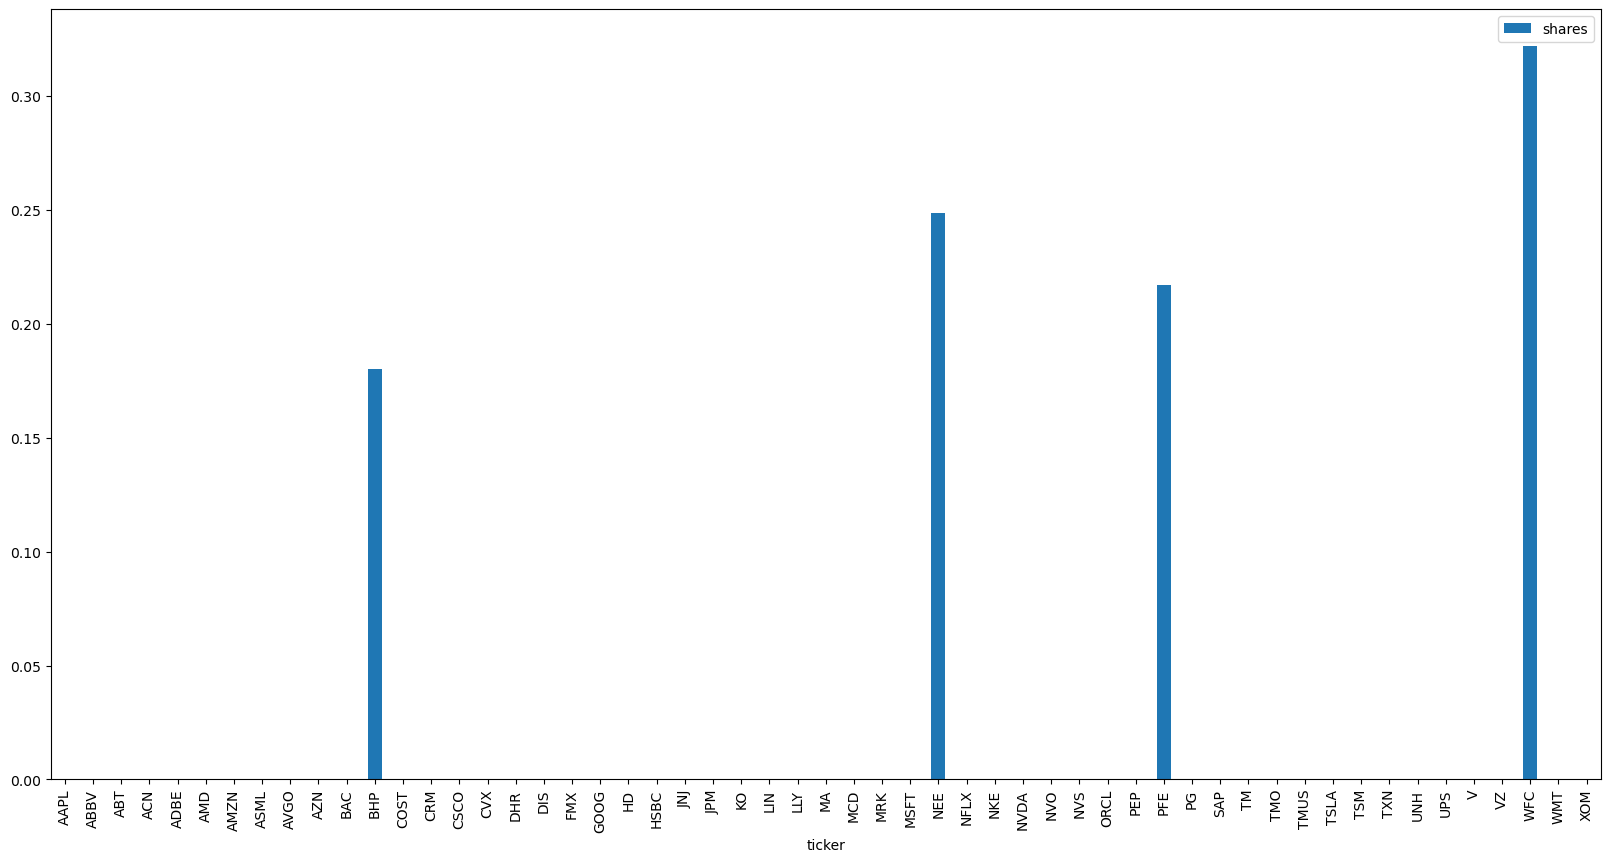

In [165]:
portfolio.plot.bar(x="ticker",y="shares",figsize=(20,10))

In [111]:
result[result.date<=inference_date].date.unique()[-17:-7]

array(['2023-05-05T00:00:00.000000000', '2023-05-08T00:00:00.000000000',
       '2023-05-09T00:00:00.000000000', '2023-05-10T00:00:00.000000000',
       '2023-05-11T00:00:00.000000000', '2023-05-12T00:00:00.000000000',
       '2023-05-15T00:00:00.000000000', '2023-05-16T00:00:00.000000000',
       '2023-05-17T00:00:00.000000000', '2023-05-18T00:00:00.000000000'],
      dtype='datetime64[ns]')

In [392]:
portfolio=pd.DataFrame([opt_tickers,res]).transpose()
portfolio.columns=["ticker","shares"]
portfolio=result[result.date==date][["ticker","Close_shift_-1"]].merge(portfolio,on="ticker",how="right")

In [393]:
portfolio

,ticker,Close_shift_-1,shares
0,AAPL,175.429993,0.0
1,ABBV,137.559998,0.0
2,ABT,102.870003,0.0
3,ACN,303.600006,0.0
4,ADBE,415.390015,0.0
5,AMD,127.029999,0.0
6,AMZN,120.110001,0.0
7,ASML,735.929993,0.0
8,AVGO,812.729980,0.0
9,AZN,72.519997,0.0


In [397]:
result.maturity_date.max()

Timestamp('2023-05-18 00:00:00')

In [151]:
def maximize_portfolio_return(tickers, stock_log_return, buy_date, price_column, log_return_column="log_return", budget=1.0):
    # Filter stock_log_return based on buy_date
    tmp = stock_log_return[stock_log_return['date'] == buy_date].copy()

    # Create a DataFrame for ticker shares
    ticker_shares = pd.DataFrame({'ticker': tickers})

    # Merge ticker_shares with filtered stock_log_return
    tmp = tmp.merge(ticker_shares, on='ticker', how='left')

    # Calculate value and budget for each date
    tmp['value'] = budget * tmp[price_column]
    tmp['budget'] = tmp['value'].sum()

    # Calculate the weight for each row
    tmp['weight'] = tmp['value'] / tmp['budget']

    # Calculate the expected log return
    expected_log_return = np.sum(tmp['weight'] * tmp[log_return_column])

    # Calculate the covariance matrix
    cov_matrix = np.cov(tmp[log_return_column], rowvar=False)

    # Define the objective function to maximize portfolio return
    def objective(weight):
        portfolio_return = np.sum(weight * tmp[log_return_column])
        return -portfolio_return

    # Define the constraint function to ensure the sum of weights is 1 and weights are non-negative
    def constraint(weight):
        return np.concatenate((np.sum(weight) - 1.0, -weight))

    # Set the bounds for each weight (0 <= weight <= 1)
    bounds = [(0, None)] * len(tickers)

    # Set the initial guess for weights (equal allocation)
    init_guess = [1 / len(tickers)] * len(tickers)

    # Define the optimization problem
    opt_problem = {'type': 'eq', 'fun': constraint}
    opt_result = minimize(objective, init_guess, method='SLSQP', bounds=bounds, constraints=opt_problem)

    # Retrieve the optimal weights
    optimal_weights = opt_result.x

    # Calculate the portfolio return with optimal weights
    portfolio_return = np.sum(optimal_weights * tmp[log_return_column])

    return optimal_weights, portfolio_return

In [141]:
res,expected_return=maximize_portfolio_return(tickers=tickers, stock_log_return=result[result.ticker.isin(tickers)], buy_date="2023-03-01", price_column="Close_shift_-1", log_return_column="pred_step_0", budget=1.0)

In [142]:
expected_return

0.01582266522851775

In [143]:
portfolio_buy_date_return(tickers=tickers,shares=res,stock_log_return=result,buy_date="2023-03-01",price_column='Close',log_return_column="log_return")

0.007019564560666403